In [1]:
#######imports and data read#######
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from pre_processing import *
from algorithms import *
from spectrum_gen import *
from data_gen import *
from analysis import *
from datasets import *
from evaluation import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
gene_list_for_plot = ['CDC20','CDK1','RRM2','PCNA']
#adata = sc.read_csv('hela/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt', delimiter='\t').T
adata = sc.read_csv('hela/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt', delimiter='\t').T
adata = shuffle_adata(adata)
adata


View of AnnData object with n_obs × n_vars = 1029 × 25797

In [2]:
#######data cleaning#######
#sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=0)
i=1
while adata.obs['n_genes'].mean() <4500: #remove cells until we reach mean counts of 4,500 as suggested by https://www.embopress.org/doi/full/10.15252/msb.20209946
    sc.pp.filter_cells(adata, min_genes=i)
    i+=5
#sc.pp.filter_cells(adata, min_counts=3000) #4000
adata_for_inference = adata.copy()
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 683 × 25797
    obs: 'n_genes'

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/scanpy/preprocessing/_deprecated/highly_variable_genes.py:145: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


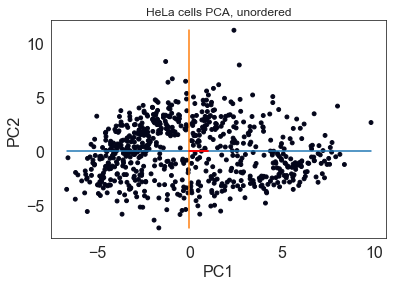

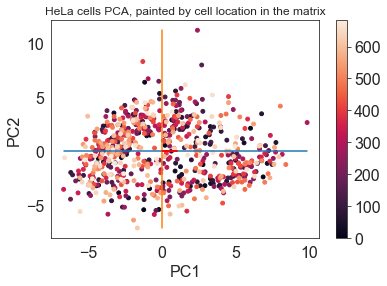

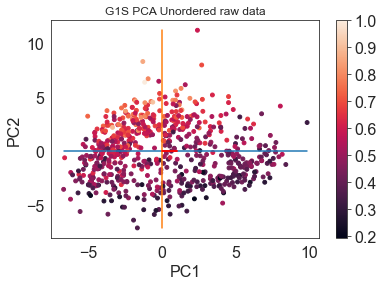

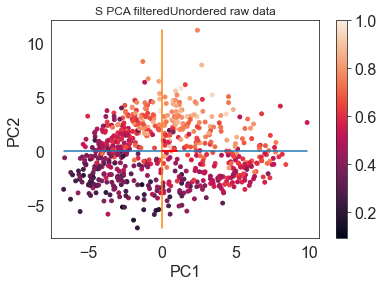

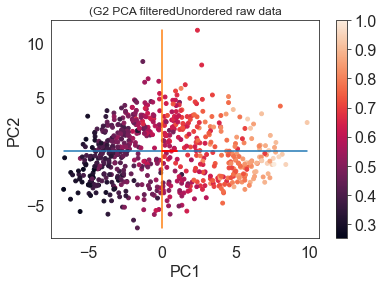

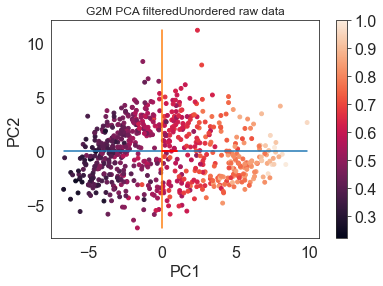

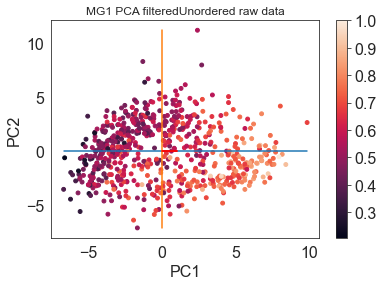

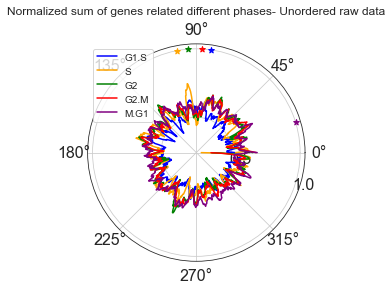

Circular mean and variance, G1S(1.4249141190090875, 0.9915606405912769)
Circular mean and variance, S(1.75774211103715, 0.9838302283111364)
Circular mean and variance, G2(1.6519776031367126, 0.9863101269819963)
Circular mean and variance, G2M(1.514887642953955, 0.9895129399138657)
Circular mean and variance, MG1(0.295349159988295, 0.997980441965775)


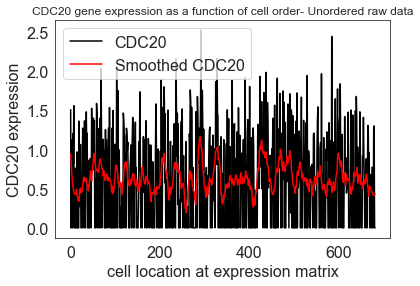

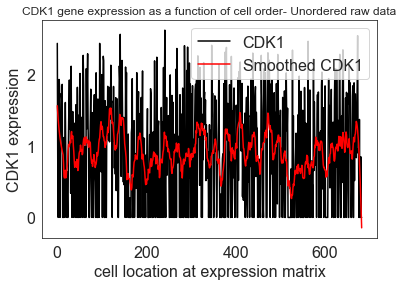

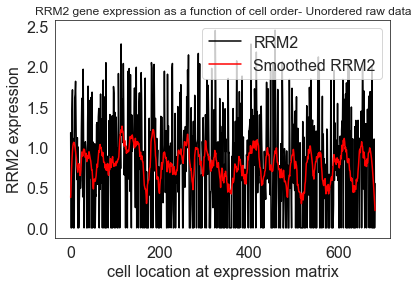

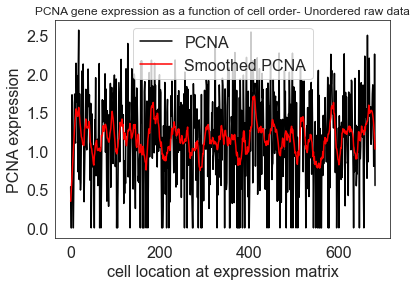

Mean AUC-ROC: 0.2920175


In [3]:
#######data cleaning#######
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
bdata = copy.deepcopy(adata.copy())
sc.pp.filter_genes_dispersion(adata,n_top_genes=7000)
ranged_pca_2d(adata.X,color=np.zeros(adata.X.shape[0]),title=("HeLa cells PCA, unordered"),dis_colorbar=True)
all_plots_hela(adata,title="Unordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='r', title="Unordered raw data")
#######Gene inference over un-ordered data- the result expected to be low#######
auc_unordered= np.zeros(100)
for i in range(100):
    auc_unordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_unordered)))

Iteration number: 0 function value= 1.1960241441540474e-22
Iteration number: 25 function value= 537.3406201055444
Iteration number: 50 function value= 560.642198248715
Iteration number: 75 function value= 564.3908784804325
Iteration number: 100 function value= 577.6096636069581
Iteration number: 125 function value= 582.6893263371528
Iteration number: 150 function value= 579.3754486743773
Iteration number: 175 function value= 584.0369584448401
Iteration number: 200 function value= 588.0730419638123
Iteration number: 225 function value= 585.7381383910936


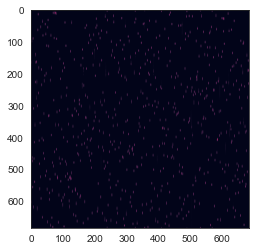

In [4]:
E_sga  , E_rec_sga = reconstruction_cyclic(adata.X , iterNum=250 , batch_size=6000)
plt.imshow(E_sga)
plt.show()

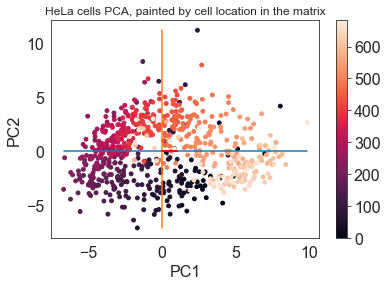

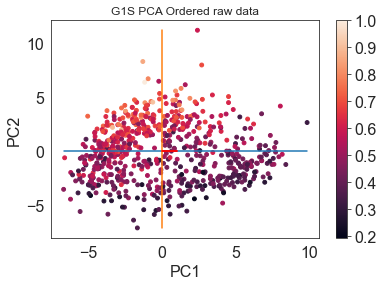

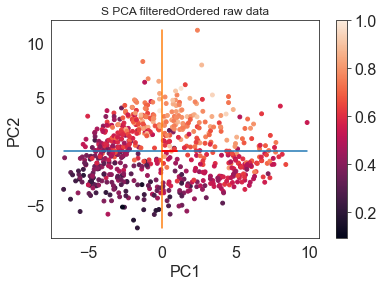

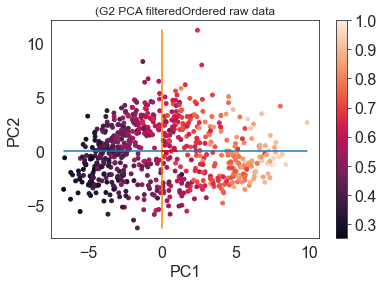

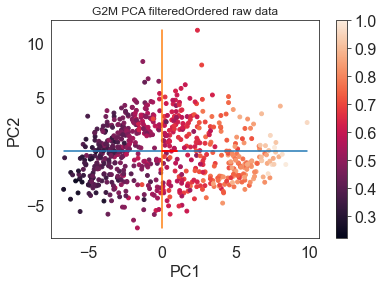

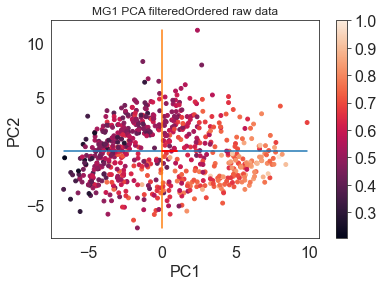

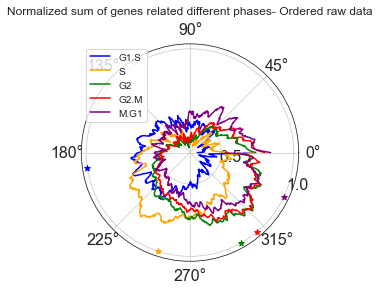

Circular mean and variance, G1S(-2.994988798109624, 0.8885931891734242)
Circular mean and variance, S(-1.8890490133840283, 0.8259244200827448)
Circular mean and variance, G2(-1.0607648098903872, 0.8090531024705665)
Circular mean and variance, G2M(-0.8736888116329302, 0.8267094666251416)
Circular mean and variance, MG1(-0.4415472538022943, 0.8907262467507109)


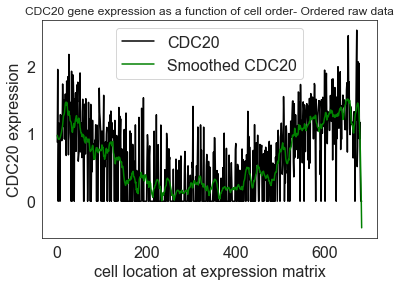

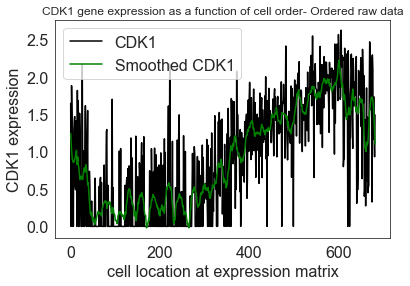

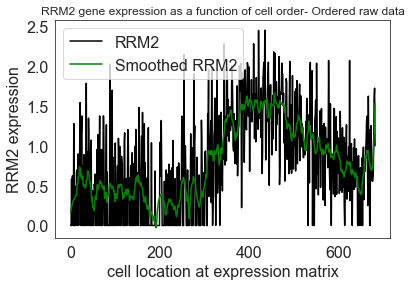

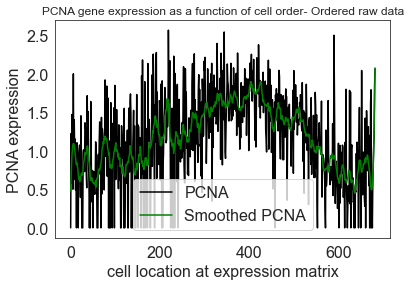

Mean AUC-ROC: 0.8084375


In [5]:
#######Signal reconstruction######
sga_range= e_to_range(E_rec_sga)
adata = adata[sga_range,:]
orig_adata = copy.deepcopy(adata.copy())
all_plots_hela(adata,title="Ordered raw data")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='g', title="Ordered raw data")
auc_ordered= np.zeros(100)
#######Gene inference over ordered data#######
for i in range(100):
    auc_ordered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_ordered)))

Iteration number: 1 function value: 512.0484246841633
Iteration number: 26 function value: 1105.494656208852
Iteration number: 51 function value: 2584.782221860724
Iteration number: 76 function value: 3388.6767366274175
norm change 448.0672608680173


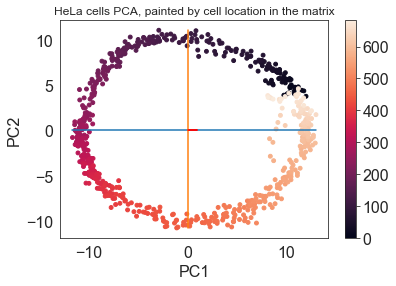

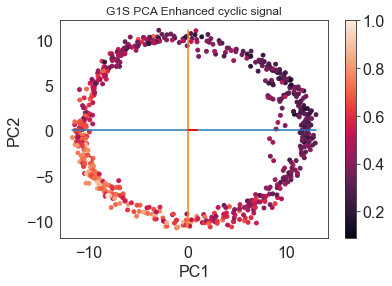

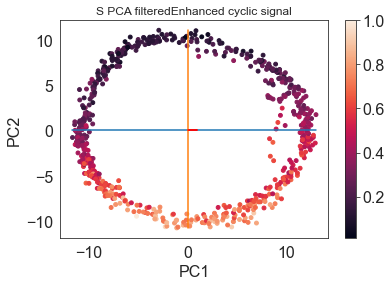

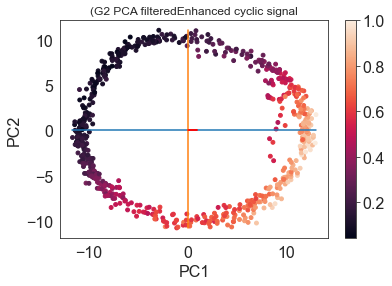

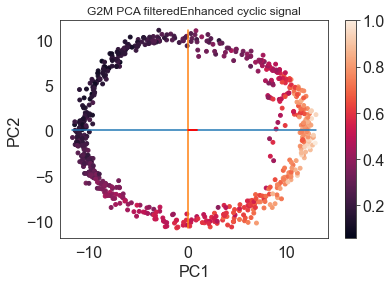

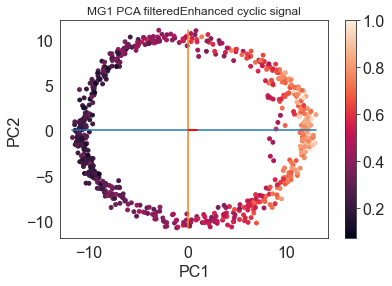

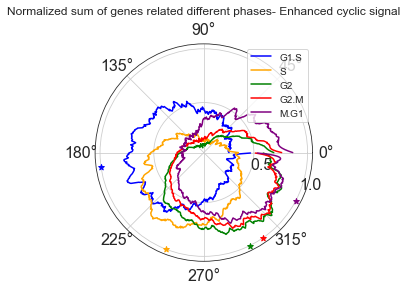

Circular mean and variance, G1S(-3.0029275457551776, 0.7827954221307842)
Circular mean and variance, S(-1.944547520456012, 0.6442266117494699)
Circular mean and variance, G2(-1.1109372712443386, 0.5606674850526181)
Circular mean and variance, G2M(-0.9645184385266742, 0.6396225060448888)
Circular mean and variance, MG1(-0.48368250590570555, 0.6953752164879373)


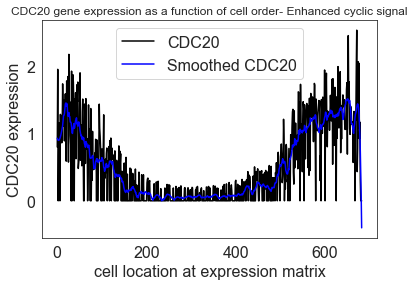

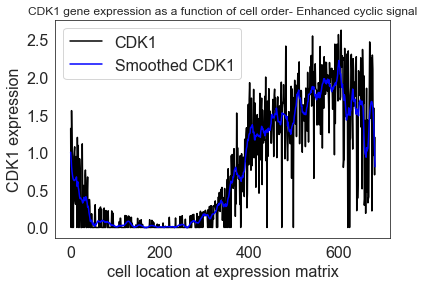

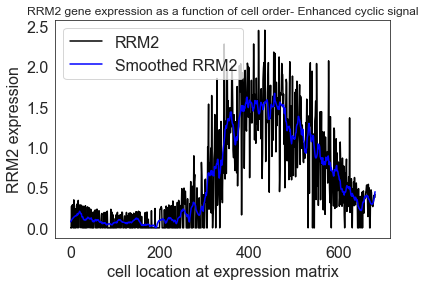

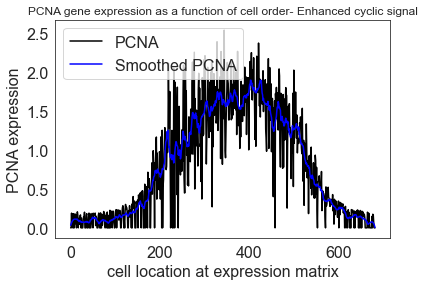

Mean AUC-ROC: 0.8391474999999997


In [6]:
#######Signal enhancement######
adata = orig_adata.copy()
F = enhancement_cyclic(adata.X,regu=0.05,iterNum=100)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Enhanced cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='b', title="Enhanced cyclic signal")
auc_en= np.zeros(100)
for i in range(100):
    auc_en[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_en)))

starting filtering
25th Iteration    Loss :: 105.34531094965877 gradient :: 2.477638689772565
50th Iteration    Loss :: 50.74471809712948 gradient :: 1.2596493460255271
75th Iteration    Loss :: 33.65801280867058 gradient :: 0.8383521904132322
100th Iteration    Loss :: 25.55873202404801 gradient :: 0.6307041637809621
125th Iteration    Loss :: 21.07963004032186 gradient :: 0.5198609593069063
150th Iteration    Loss :: 18.135904443870103 gradient :: 0.4517652514438402
175th Iteration    Loss :: 16.038234495188963 gradient :: 0.4104715976511788
200th Iteration    Loss :: 14.475097076965394 gradient :: 0.33332333951612236
225th Iteration    Loss :: 13.242868421550853 gradient :: 0.2952805448716592
250th Iteration    Loss :: 12.239706704376815 gradient :: 0.27506719168464366
275th Iteration    Loss :: 11.412627815366191 gradient :: 0.2625348543258017
300th Iteration    Loss :: 10.719893526170555 gradient :: 0.23846966937818015
325th Iteration    Loss :: 10.129416635522876 gradient :: 0.21

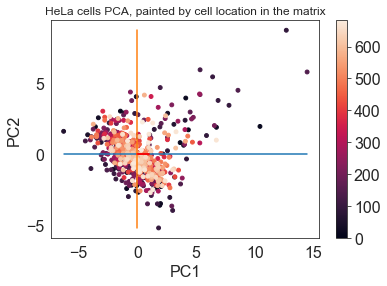

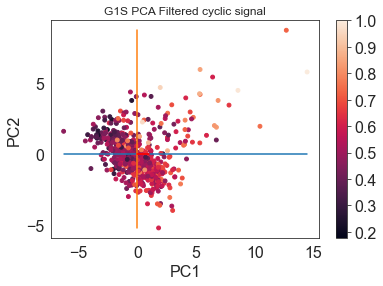

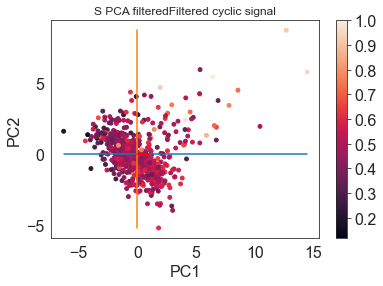

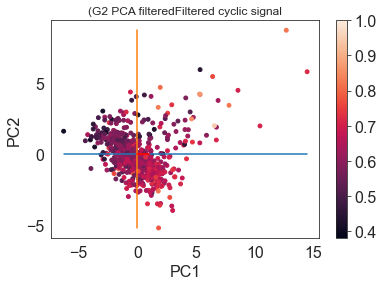

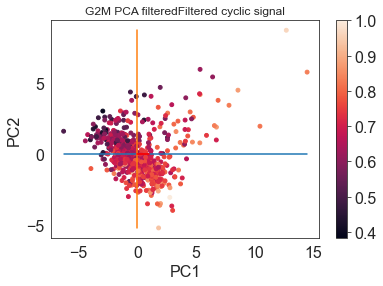

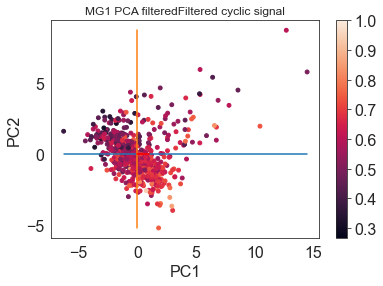

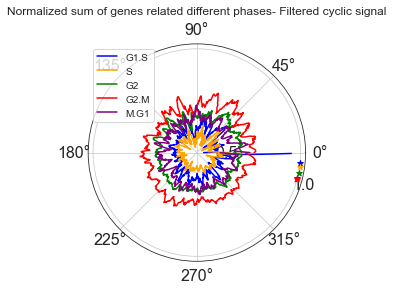

Circular mean and variance, G1S(-0.10534630064604561, 0.9902559384550892)
Circular mean and variance, S(-0.1357122704536846, 0.9896210438724702)
Circular mean and variance, G2(-0.2007432645996346, 0.9893643811472737)
Circular mean and variance, G2M(-0.2561788184656596, 0.9889936510936427)
Circular mean and variance, MG1(-0.2519509566284147, 0.9889765706980764)


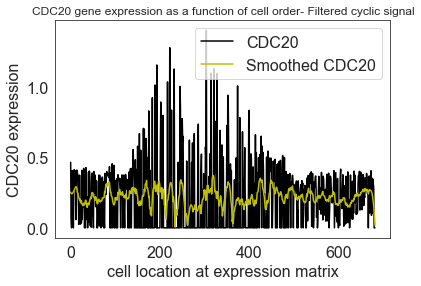

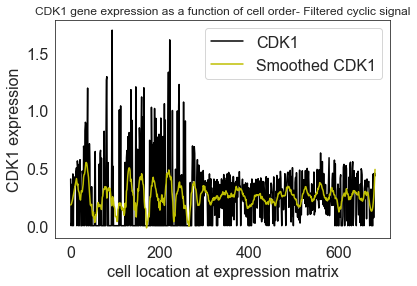

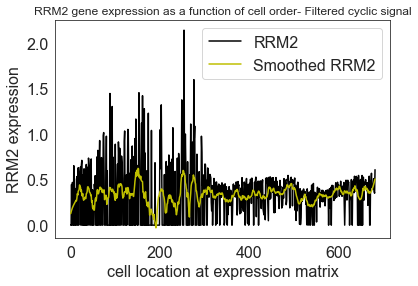

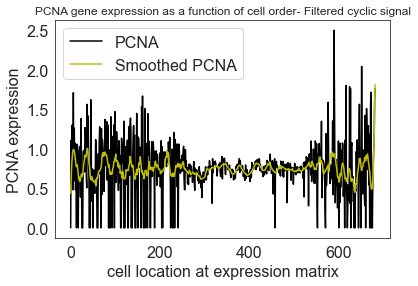

Mean AUC-ROC: 0.1876295


In [7]:
#######Signal filtering######
adata = copy.deepcopy(orig_adata.copy())
F = filtering_cyclic(adata.X,regu=0,iterNum=1500)
print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
adata.X = adata.X * F
all_plots_hela(adata,title="Filtered cyclic signal")
plot_gene_list(adata, gene_list_for_plot, color1='black', color2='y', title="Filtered cyclic signal")
auc_filtered= np.zeros(100)
for i in range(100):
    auc_filtered[i] = hela_gene_inference(adata, number_of_genes=100)
print("Mean AUC-ROC: " + str(np.mean(auc_filtered)))

starting norm: 885.0457
Iteration number: 1 function value: 512.0432310934847
norm change 48.28691074318816


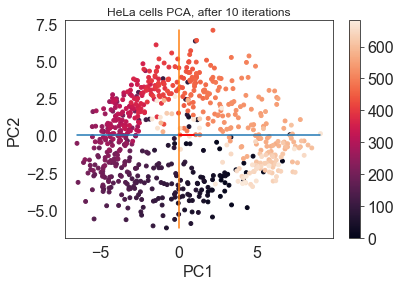

Iteration number: 1 function value: 512.0342626866682
norm change 108.96600862883021


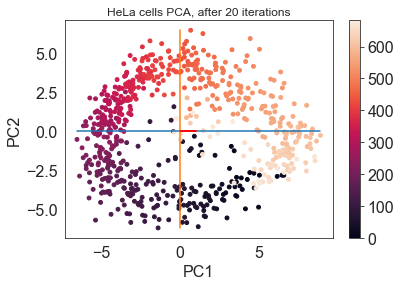

Iteration number: 1 function value: 512.0458461987076
Iteration number: 26 function value: 1105.4100825524033
norm change 192.30449692764972


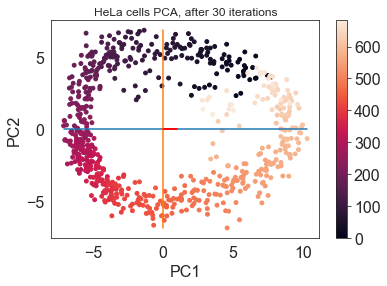

Iteration number: 1 function value: 512.0434011153571
Iteration number: 26 function value: 1105.72529503905
norm change 261.19839054419526


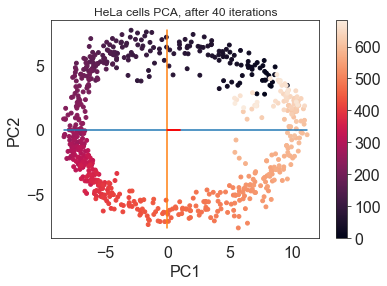

Iteration number: 1 function value: 512.0423688718755
Iteration number: 26 function value: 1105.3836504170417
norm change 311.2285495525544


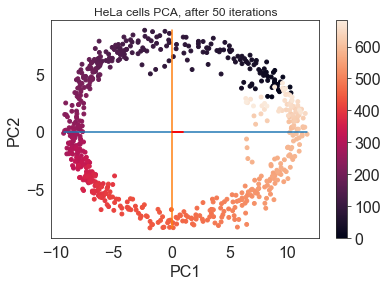

Iteration number: 1 function value: 512.043213430435
Iteration number: 26 function value: 1105.923632084721
Iteration number: 51 function value: 2584.2734589258616
norm change 347.2309891335868


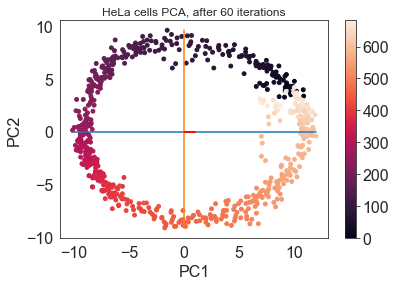

Iteration number: 1 function value: 512.0269091510231
Iteration number: 26 function value: 1105.3675519444175
Iteration number: 51 function value: 2584.3192170151087
norm change 377.3680845913425


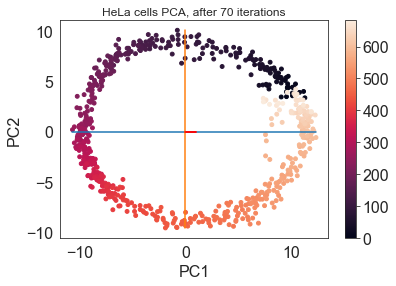

Iteration number: 1 function value: 512.0306286810069
Iteration number: 26 function value: 1105.7915278610046
Iteration number: 51 function value: 2584.1539417427316
Iteration number: 76 function value: 3388.0204399030986
norm change 404.29432194727514


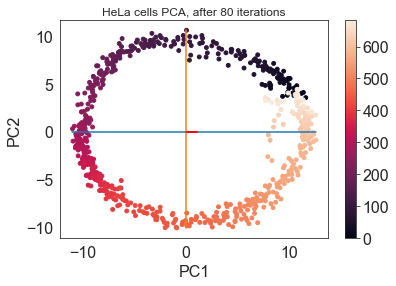

Iteration number: 1 function value: 512.0336326751247
Iteration number: 26 function value: 1105.1101768679732
Iteration number: 51 function value: 2584.1810937922714
Iteration number: 76 function value: 3388.4339321845932
norm change 427.6236898981255


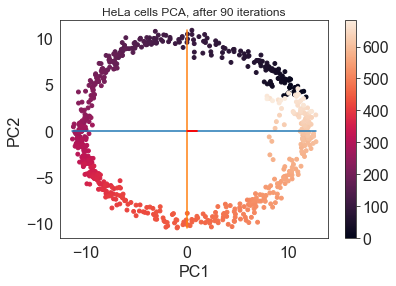

Iteration number: 1 function value: 512.0440302618131
Iteration number: 26 function value: 1105.6365599274882
Iteration number: 51 function value: 2584.7417231899008
Iteration number: 76 function value: 3389.2780015457865
norm change 448.03574277104553


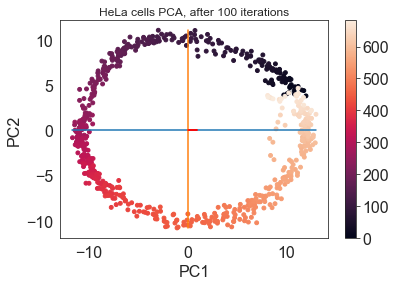

In [8]:
print("starting norm: " +str(np.linalg.norm(orig_adata.X)))
adata = copy.deepcopy(orig_adata.copy())
for i in range(10):
    adata = copy.deepcopy(orig_adata.copy())
    F = enhancement_cyclic(adata.X,regu=0.05,iterNum=(10*(i+1)))
    print("norm change " +str(np.linalg.norm(orig_adata.X - adata.X * F)))
    adata.X = adata.X * F
    ranged_pca_2d(adata.X,color=range(adata.X.shape[0]),title=("HeLa cells PCA, after "+ str((i+1)*10) +" iterations"))

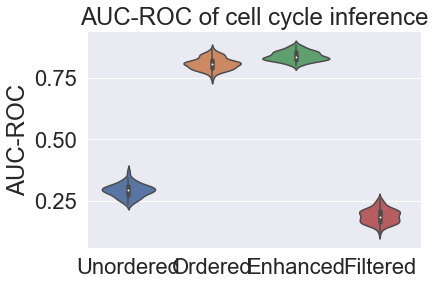

In [9]:
data = pd.DataFrame({
    "Unordered": auc_unordered,
    'Ordered': auc_ordered,
    "Enhanced": auc_en,
    "Filtered": auc_filtered,
})
sns.set_style("whitegrid")

sns.set_style("white", {"axes.facecolor": ".9"})
sns.set_style("whitegrid")

sns.set(font_scale=2)
ax = sns.violinplot(data=data)
plt.ylabel("AUC-ROC")
plt.title("AUC-ROC of cell cycle inference" ,fontsize='24')
plt.show()

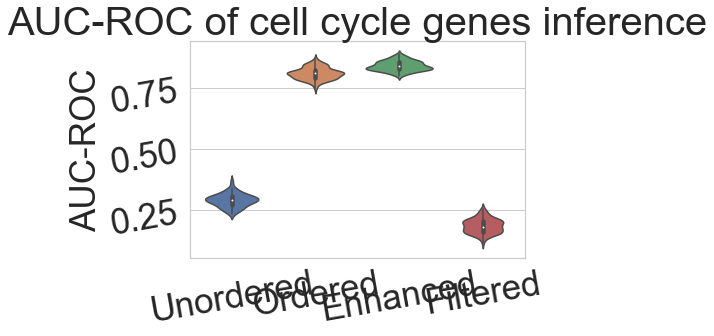

In [10]:
sns.set_style("whitegrid")

b = sns.violinplot(data=data)
#b.axes.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={'figure.figsize':(23.4,16.54)})
b.axes.set_title("AUC-ROC of cell cycle genes inference",fontsize=40)
b.set_ylabel("AUC-ROC",fontsize=35)
b.tick_params(rotation=10,labelsize=35)
#b.axes.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


sns.set(rc={'figure.figsize':(23.4,16.54)})
#plt.title("MSE between simulated cyclic signal and output of enhancement methods" ,fontsize='24')

sns.set_style("whitegrid")

plt.show()